# Example: Define hydrological model regions

The first step when building a model is to define the model domain. For hydrological models this is typically a full **basin** or **sub-basin** which includes all upstream cells. For hydrodynamic models this can also be an **inter-basin** which does not necessary include all upstream cells. *HydroMT* has the [get_basin_geometry()](../_generated/hydromt.model.processes.basin_mask.get_basin_geometry.rst) method to do just that. 

## Import packages

In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box

In [2]:
# for plotting
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt

proj = ccrs.PlateCarree()  # plot projection

In [3]:
import hydromt
from hydromt.model.processes.basin_mask import get_basin_geometry

## Read data

Read data using the [DataCatalog](../_generated/hydromt.data_catalog.DataCatalog.rst). If no yml files with data sources are provided, by default data for the Piave basin is downloaded from the hydromt-artifacts to to `~/.hydromt_data/`. Links to the original data sources and data licenses can be found in the meta dict of each source. Here we use flow direction data from [MERIT Hydro](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro). Note that the original `'MERIT Hydro'` data has been extended with a basin mask layer, which together with the basin index vector data makes faster basin delineation possible.

In [4]:
# instantiate instance of Data Catalog
data_catalog = hydromt.DataCatalog(data_libs=["artifact_data=v1.0.0"])

In [5]:
# read MERIT hydro flow direction data
print(data_catalog.get_source("merit_hydro"))
ds = data_catalog.get_rasterdataset("merit_hydro")

name='merit_hydro' uri='merit_hydro/{variable}.tif' data_adapter=RasterDatasetAdapter(unit_add={}, unit_mult={}, rename={}) driver=RasterioDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7ceef6958430>, options={}) uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7ceef6958430>, options={}) root='/home/sam/.hydromt/artifact_data/v1.0.0' version='1.0' provider=None metadata=SourceMetadata(crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=None, attrs={}, category='topography', paper_doi='10.1029/2019WR024873', paper_ref='Yamazaki et al. (2019)', url='http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro', license='CC-BY-NC 4

In [6]:
# read MERIT hydro basin index vector data. This data contains bounding box geometries of all basins globally.
# Here we pass the GeoDataFrameAdapter instead of the GeoDataFrame itself
# a spatial subset of the data loaded within the get_basin_geometry method
basin_index = data_catalog.get_source("merit_hydro_index")
print(basin_index)

name='merit_hydro_index' uri='merit_hydro_index.gpkg' data_adapter=GeoDataFrameAdapter(unit_add={}, unit_mult={}, rename={}) driver=PyogrioDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7ceef6958430>, options={}) uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x7ceef6958430>, options={}) root='/home/sam/.hydromt/artifact_data/v1.0.0' version=None provider=None metadata=SourceMetadata(crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=None, attrs={}, category='topography', paper_doi='10.5194/hess-2020-582', paper_ref='Eilander et al. (in review)', license='CC-BY-NC 4.0')


In [7]:
# derive river geometry based on stream order >= 7 (for plotting only)
flwdir = hydromt.gis.flw.flwdir_from_da(ds["flwdir"], ftype="d8")
feats = flwdir.streams(mask=ds["strord"] >= 7)
gdf_riv = gpd.GeoDataFrame.from_features(feats)


def plot(extent, gdf_bas, gdf_out):
    plt.figure(figsize=(3, 5))
    ax = plt.subplot(projection=proj)
    ax.set_extent(extent, crs=proj)
    ax.add_image(cimgt.QuadtreeTiles(), 10)
    gdf_bas.boundary.plot(ax=ax, edgecolor="k", zorder=2)
    gdf_riv.plot(ax=ax, color="blue", alpha=0.7)
    gdf_out.plot(ax=ax, markersize=40, c="red", zorder=2)
    return ax

## Delineate basins

Several examples to delineate sub-, inter- or full basins are provided below together with the command line interface (CLI) syntax for the HydroMT [build](../guides/user_guide/model_build.rst) command. All CLI options are described in the [parse_region_basin()](../_generated/hydromt.model.processes.region.parse_region_basin.rst) method.

Get the basin based on a point location `[x, y]`.

In [8]:
# CLI syntax: -r {'basin': [x, y]}
# e.g.: -r {'basin': [12.6, 45.8]}

xy = [12.6, 45.8]
gdf_bas, _ = get_basin_geometry(
    ds,
    kind="basin",
    xy=xy,
    basin_index=basin_index,
)

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((12.7 45.7, 12.7 45.9, 12.5 45.9, 12.....


object: PyogrioDriver does not use kwarg predicate with value intersects.


object: PyogrioDriver does not use kwarg metadata with value crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 unit=None extent={} nodata=None attrs={} category='topography' paper_doi='10.5194/hess-2020-582' paper_ref='Eilander et al. (in review)' license='CC-BY-NC 4.0'.


/tmp/ipykernel_100405/1510890054.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  extent = np.array(gdf_bas.buffer(0.1).total_bounds)[[0, 2, 1, 3]]


<GeoAxes: >

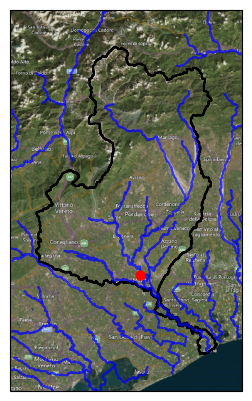

In [9]:
# plot results
gdf_xy = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[xy[0]], y=[xy[1]]), crs=4326)
extent = np.array(gdf_bas.buffer(0.1).total_bounds)[[0, 2, 1, 3]]

plot(extent, gdf_bas, gdf_xy)

## Delineate sub-basins

We need an initial bounding box to delineate the sub-basin. This can be derived from the *merit_hydro_index* or user provided initial `bounds`. 
The latter might be faster if delineating a small sub-basin from a large basin. A warning is raised if not all contributing cells are included.

Get a subbasin based on its outlet location `[x,y]`, snapped to a stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 7. The `variable` should be present in the dataset `ds`. 

In [10]:
# CLI syntax: -r {'subbasin': [x, y], <variable>: <threshold>, 'bounds': [xmin, ymin, xmax, ymax]}
# e.g.: -r {'subbasin': [12.6, 45.8], 'strord': 7, 'bounds': [12.1, 45.5, 12.9, 46.5]}

xy = [12.6, 45.8]
bounds = [12.1, 45.5, 12.9, 46.5]
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind="subbasin",
    xy=xy,
    strord=7,
    bounds=bounds,
)

/tmp/ipykernel_100405/3041410776.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  extent = gdf_bounds.buffer(0.05).total_bounds[[0, 2, 1, 3]]


<GeoAxes: >

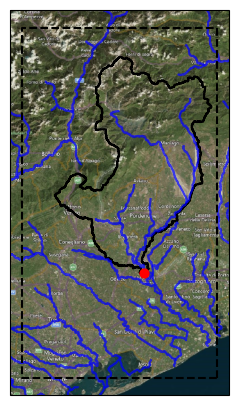

In [11]:
# plot results
gdf_bounds = gpd.GeoDataFrame(geometry=[box(*bounds)], crs=4326)
extent = gdf_bounds.buffer(0.05).total_bounds[[0, 2, 1, 3]]

ax = plot(extent, gdf_bas, gdf_out)
gdf_bounds.boundary.plot(ax=ax, edgecolor="k", ls="--")

Get a sub-basin based on the location where the stream flows out of a `bbox`. Here the stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 8. The `variable` should be present in the dataset `ds`. 

In [12]:
# CLI SYNTAX: -r {'subbasin': [xmin, ymin, xmax, ymax], <variable>: <threshold>}
# e.g.: -r {'subbasin': [12.50, 45.72, 12.7, 46], 'strord': 8}

bbox = [12.50, 45.72, 12.7, 46]
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind="subbasin",
    bbox=bbox,
    strord=8,
    basin_index=basin_index,
)

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((12.7 45.72, 12.7 46, 12.5 46, 12.5 4....


object: PyogrioDriver does not use kwarg predicate with value intersects.


object: PyogrioDriver does not use kwarg metadata with value crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 unit=None extent={} nodata=None attrs={} category='topography' paper_doi='10.5194/hess-2020-582' paper_ref='Eilander et al. (in review)' license='CC-BY-NC 4.0'.


/tmp/ipykernel_100405/2647821985.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  extent = gdf_bas.buffer(0.05).total_bounds[[0, 2, 1, 3]]


<GeoAxes: >

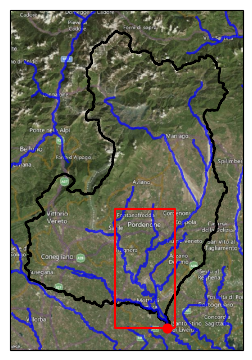

In [13]:
# plot results
gdf_bbox = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=4326)
extent = gdf_bas.buffer(0.05).total_bounds[[0, 2, 1, 3]]

ax = plot(extent, gdf_bas, gdf_out)
gdf_bbox.boundary.plot(ax=ax, edgecolor="r", ls="-")

## Delineate interbasins

Get an inter-basin based on the streams within a `bbox`. The inter-basin is limited to the most downstream contiguous area within the bbox that drains to the stream.  Here the stream defined by a `<variable>:<threshold>` pair, in this case a stream order larger or equal to 8. The `variable` should be present in the dataset `ds`. The `buffer` is required to check wether streams flow in and out of the bbox. 

In [14]:
# CLI SYNTAX -r {'interbasin': [xmin, ymin, xmax, ymax], <variable>: <threshold>}
# e.g.: -r {'interbasin': [12.50, 45.72, 12.7, 46], 'strord': 8}

bbox = [12.50, 45.72, 12.7, 46]
gdf_bas, gdf_out = get_basin_geometry(
    ds,
    kind="interbasin",
    bbox=bbox,
    strord=8,
    buffer=20,
)

/tmp/ipykernel_100405/1881121779.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  extent = gdf_bbox.buffer(0.02).total_bounds[[0, 2, 1, 3]]


<GeoAxes: >

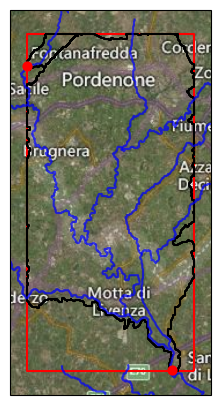

In [15]:
# plot results
gdf_bbox = gpd.GeoDataFrame(geometry=[box(*bbox)], crs=4326)
extent = gdf_bbox.buffer(0.02).total_bounds[[0, 2, 1, 3]]

ax = plot(extent, gdf_bas, gdf_out)
gdf_bbox.boundary.plot(ax=ax, edgecolor="r", ls="-", zorder=1)